In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler 
import os, cv2


In [38]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [39]:
y = data['label']
x = data.drop(columns = ['label'])

In [40]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [41]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

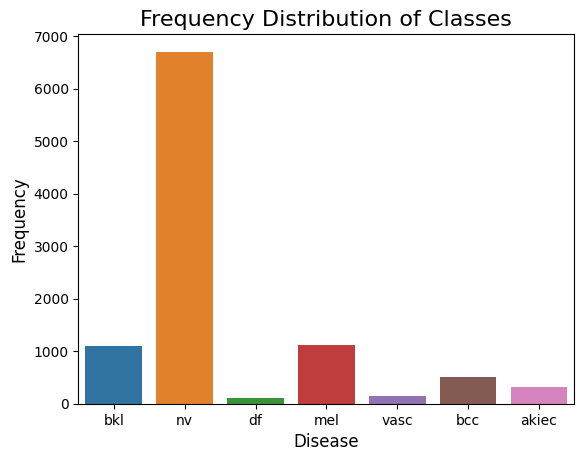

In [42]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

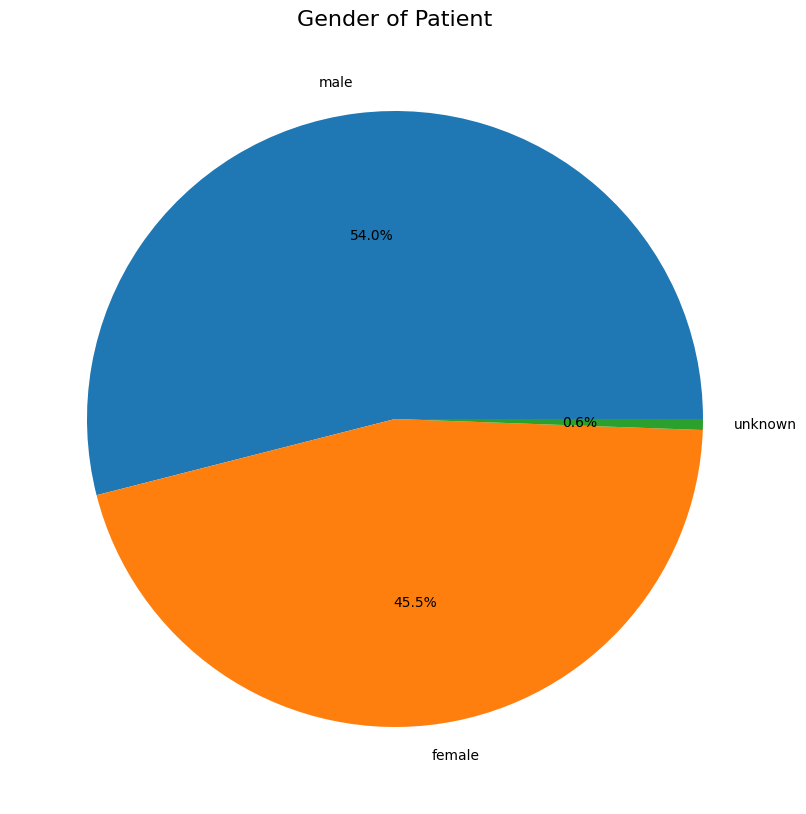

In [43]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Age of Patients')

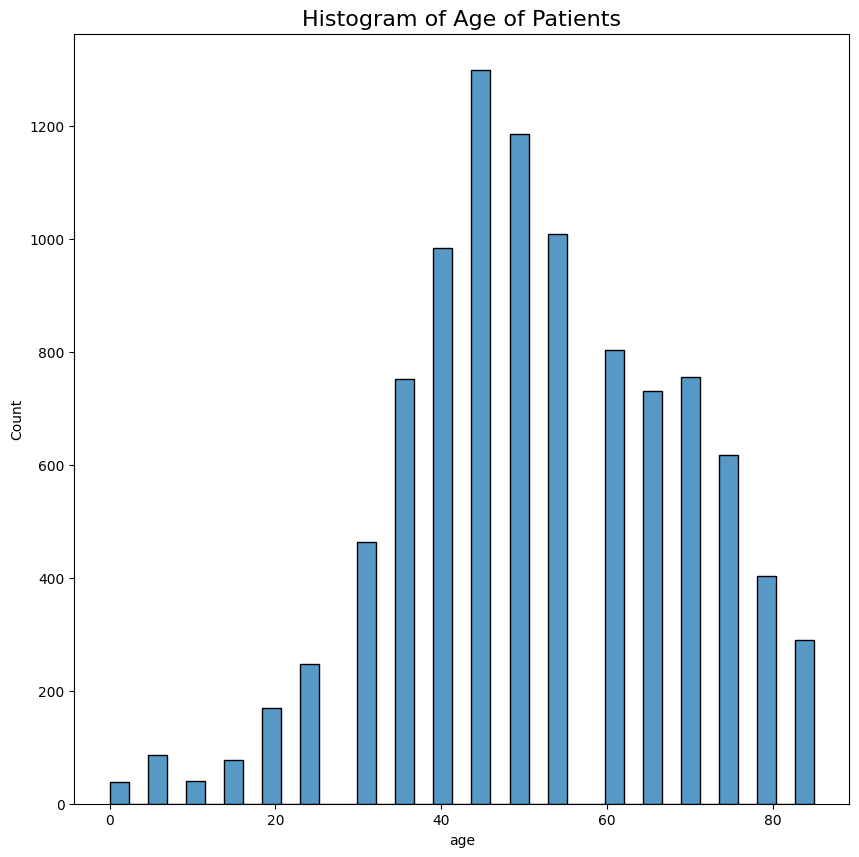

In [44]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

Text(0.5, 1.0, 'Gender of Patient')

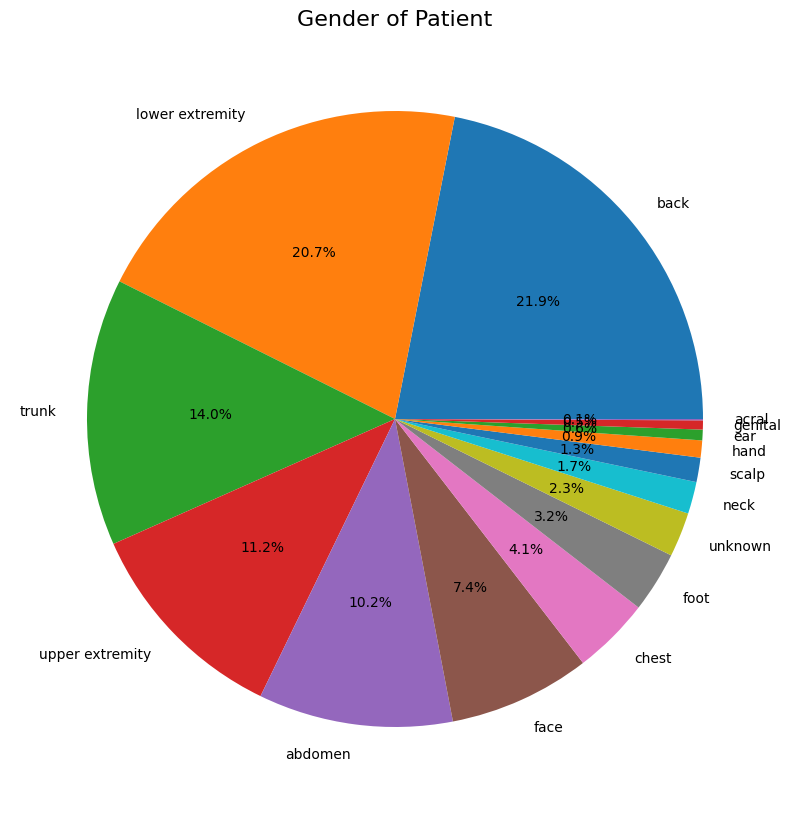

In [45]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['localization'].value_counts(), labels = tabular_data['localization'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

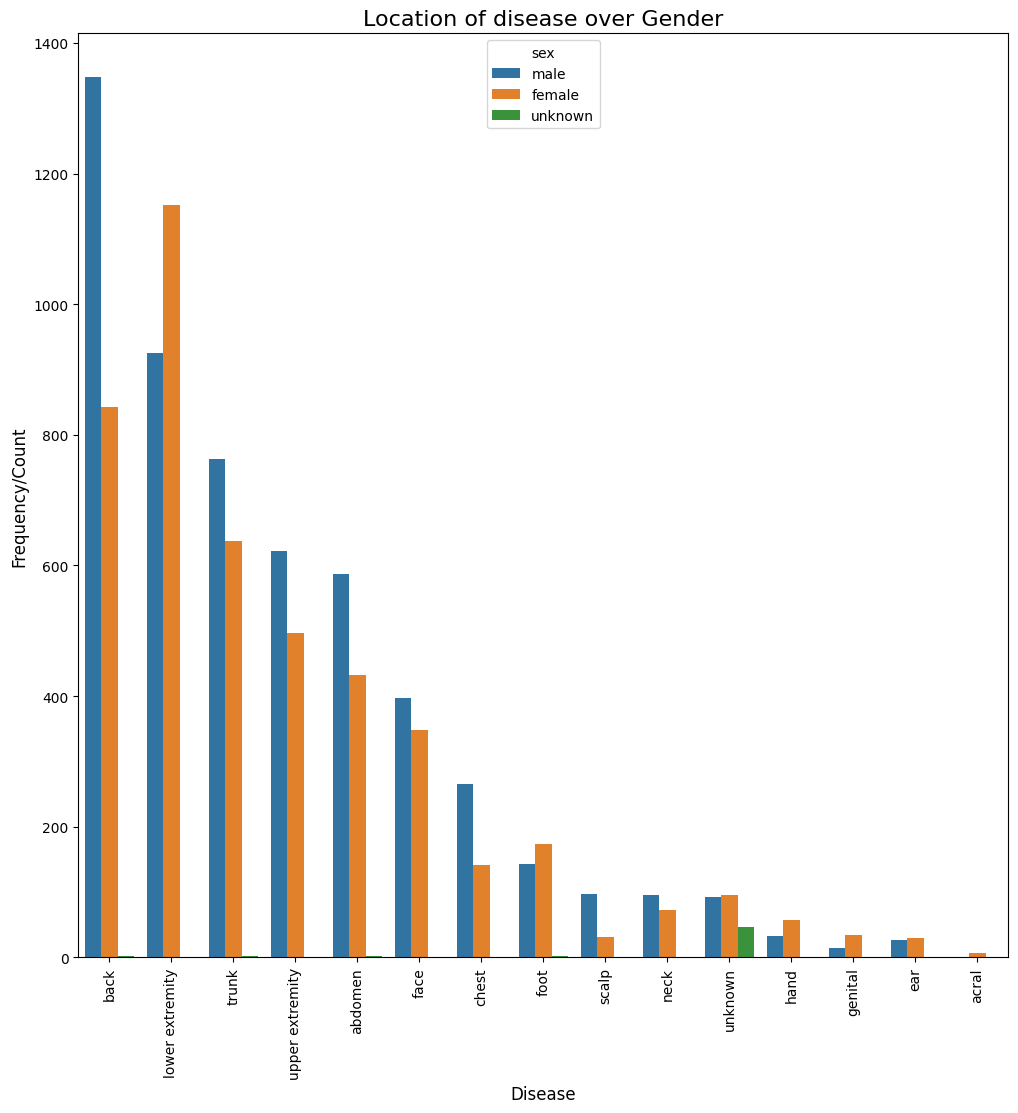

In [46]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [47]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [48]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [49]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

*USING MOBILE NET*


In [54]:
X_train_resized = np.array([resize(image, (32, 32, 3)) for image in X_train])
X_test_resized = np.array([resize(image, (32, 32, 3)) for image in X_test])


base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) 

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)

model_mobilenet.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


model_mobilenet.summary()

/tmp/ipykernel_33/530107863.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 16, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 8, 8, 64)       │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 8, 8, 128)      │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,368,775 (12.85 MB)

 Trainable params: 3,346,887 (12.77 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [59]:
history = model_mobilenet.fit(X_train_resized, Y_train, epochs=20, batch_size=32, validation_split=0.2)


model_mobilenet.save_weights('model_mobilenet.weights.h5')


for epoch, val_acc in enumerate(history.history['val_accuracy'], 1):
    print(f"Epoch {epoch}: Validation Accuracy: {val_acc:.4f}")




Epoch 1/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 212s 225ms/step - accuracy: 0.9324 - loss: 0.2011 - val_accuracy: 0.9308 - val_loss: 0.2197
Epoch 2/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 262s 225ms/step - accuracy: 0.9378 - loss: 0.1908 - val_accuracy: 0.9381 - val_loss: 0.1925
Epoch 3/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 268s 231ms/step - accuracy: 0.9460 - loss: 0.1674 - val_accuracy: 0.9458 - val_loss: 0.2008
Epoch 4/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 215s 229ms/step - accuracy: 0.9538 - loss: 0.1475 - val_accuracy: 0.9566 - val_loss: 0.1374
Epoch 5/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 264s 231ms/step - accuracy: 0.9656 - loss: 0.1083 - val_accuracy: 0.9084 - val_loss: 0.2312
Epoch 6/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 260s 229ms/step - accuracy: 0.9632 - loss: 0.1225 - val_accuracy: 0.9542 - val_loss: 0.1428
Epoch 7/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 259s 226ms/step - accuracy: 0.9715 - loss: 0.0969 - val_accuracy: 0.9582 - val_loss: 0.1238
Epoch 8/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 209s 222ms/step - accuracy: 0.9717 -

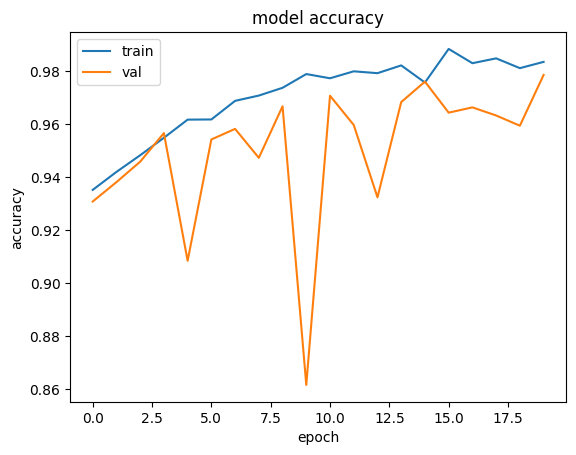

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
loss, acc = model_mobilenet.evaluate(X_test, Y_test, verbose=2)

294/294 - 5s - 15ms/step - accuracy: 0.1448 - loss: nan
